In [40]:
import json
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import textstat
from spellchecker import SpellChecker

In [42]:
json_file_path ="Cell_Phones_and_Accessories_5.json"
df = pd.read_json(json_file_path, lines=True)

In [44]:
df = df.iloc[188074:]

df = df.drop(df.index[376148:1128437])

output_path = "updated_dataset.json"
df.to_json(output_path, orient="records", lines=True)

print(f"Removed first 188074 rows and rows from 376148 to 1,128,437.")
print(f"New dataset saved as '{output_path}'.")

Removed first 188074 rows and rows from 376148 to 1,128,437.
New dataset saved as 'updated_dataset.json'.


In [46]:
print("\nStep 1: Loaded dataset.\n\n")
print(df.head())


Step 1: Loaded dataset.


        overall  verified   reviewTime      reviewerID        asin  \
188074        4      True  12 20, 2013  A2D031MY7EGYPL  B00AK4JUA2   
188075        5      True  12 17, 2013  A3V37YH9NLG6PD  B00AK4JUA2   
188076        3     False  08 19, 2014  A1J1UXRRC6YAWI  B00AK574JA   
188077        1      True   08 9, 2014  A3EKHJ6K8M8HIQ  B00AK574JA   
188078        3      True   12 8, 2013  A3TRDZ5S6D9KXO  B00AK4JUA2   

                                                    style    reviewerName  \
188074  {'Size:': ' Design case', 'Color:': ' Black', ...  Kristy Jackson   
188075  {'Size:': ' Design case', 'Color:': ' Black', ...       D Angeles   
188076  {'Size:': ' iphone 4/4s case', 'Color:': ' Pin...  Manny Gonzalez   
188077  {'Size:': ' iphone 4/4s case', 'Color:': ' Pin...    Natalie Lund   
188078  {'Size:': ' s3 case', 'Color:': ' Navy Blue', ...             Ken   

                                               reviewText  \
188074  It's a bit bulky but

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376148 entries, 188074 to 564221
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         376148 non-null  int64 
 1   verified        376148 non-null  bool  
 2   reviewTime      376148 non-null  object
 3   reviewerID      376148 non-null  object
 4   asin            376148 non-null  object
 5   style           207265 non-null  object
 6   reviewerName    376105 non-null  object
 7   reviewText      375927 non-null  object
 8   summary         375988 non-null  object
 9   unixReviewTime  376148 non-null  int64 
 10  vote            28017 non-null   object
 11  image           4391 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 31.9+ MB


In [50]:
df.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             168883
reviewerName          43
reviewText           221
summary              160
unixReviewTime         0
vote              348131
image             371757
dtype: int64

In [52]:
df.describe()

,overall,unixReviewTime
count,376148.000000,3.761480e+05
mean,4.251420,1.429191e+09
std,1.207305,3.084221e+07
min,1.000000,1.210205e+09
25%,4.000000,1.410394e+09
50%,5.000000,1.425082e+09
75%,5.000000,1.446595e+09
max,5.000000,1.533514e+09


In [54]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

In [56]:
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = df[col].fillna(df[col].mean()) 

for col in df.select_dtypes(include=['object']).columns:
    mode_value = df[col].mode()
    if isinstance(mode_value[0], list):  
        mode_value = mode_value[0][0]  
    df[col] = df[col].fillna(mode_value[0]) 

In [58]:
print("\nStep 2: Handling Missing values.\n\n")
df.isnull().sum()


Step 2: Handling Missing values.




overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             168883
reviewerName           0
reviewText             0
summary                0
unixReviewTime         0
vote                   0
image                  0
dtype: int64

In [60]:

print("\nStep 3: Encoding Categorical Data.\n\n")




Step 3: Encoding Categorical Data.




In [62]:
print("\nStep 4: Feature Scaling.\n")
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
print(df.head())


Step 4: Feature Scaling.

        overall  verified   reviewTime      reviewerID        asin  \
188074     0.75      True  12 20, 2013  A2D031MY7EGYPL  B00AK4JUA2   
188075     1.00      True  12 17, 2013  A3V37YH9NLG6PD  B00AK4JUA2   
188076     0.50     False  08 19, 2014  A1J1UXRRC6YAWI  B00AK574JA   
188077     0.00      True   08 9, 2014  A3EKHJ6K8M8HIQ  B00AK574JA   
188078     0.50      True   12 8, 2013  A3TRDZ5S6D9KXO  B00AK4JUA2   

                                                    style    reviewerName  \
188074  {'Size:': ' Design case', 'Color:': ' Black', ...  Kristy Jackson   
188075  {'Size:': ' Design case', 'Color:': ' Black', ...       D Angeles   
188076  {'Size:': ' iphone 4/4s case', 'Color:': ' Pin...  Manny Gonzalez   
188077  {'Size:': ' iphone 4/4s case', 'Color:': ' Pin...    Natalie Lund   
188078  {'Size:': ' s3 case', 'Color:': ' Navy Blue', ...             Ken   

                                               reviewText  \
188074  It's a bit bulky but

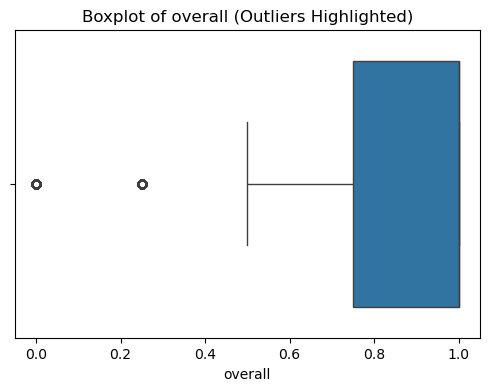

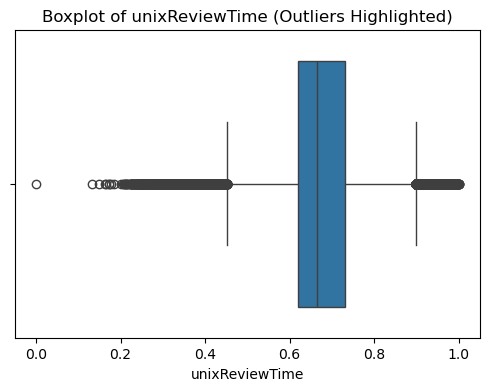


Step 5: Removed outliers using IQR method.

Remaining rows after outlier removal: 323210


In [64]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col} (Outliers Highlighted)')
        plt.show()

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers(df, numerical_columns)
print("\nStep 5: Removed outliers using IQR method.\n")
print(f"Remaining rows after outlier removal: {len(df)}")


Step 6: Correlation Matrix Heatmap



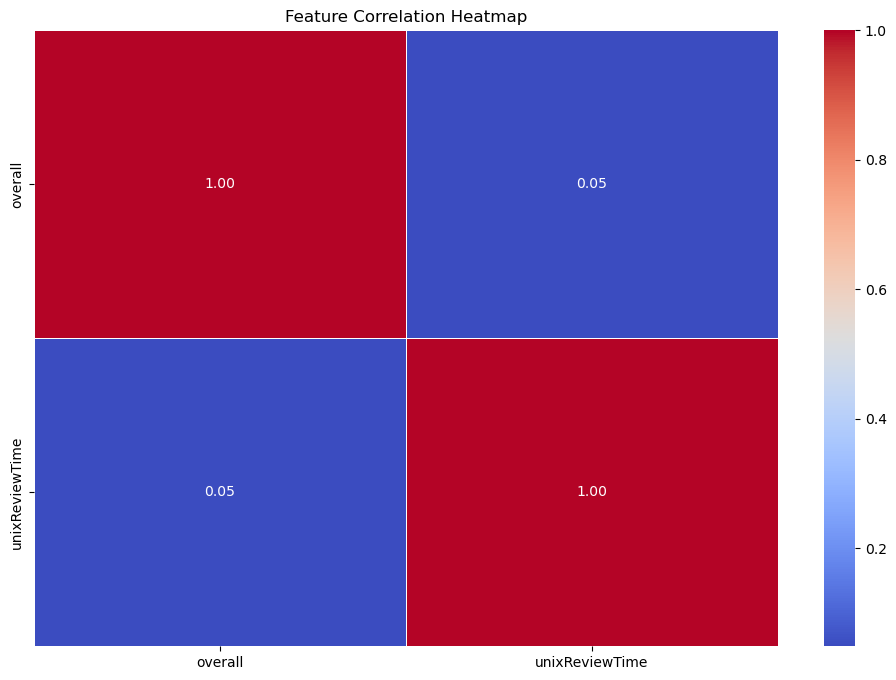

In [65]:
print("\nStep 6: Correlation Matrix Heatmap\n")

plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [66]:
print(df.columns)

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image'],
      dtype='object')


In [70]:
df = df.sort_values(by=['reviewerID', 'unixReviewTime']).reset_index(drop=True)

In [72]:
def calculate_helpfulness(row):
    return row['overall'] / 5

df['helpfulness_score'] = df.apply(calculate_helpfulness, axis=1)

In [74]:
def calculate_recent_score(group):
    n = len(group)
    z_ij = []
    for i in range(n):
        score = sum(1 / (e ** 2) for e in range(1, n - i + 1))
        z_ij.append(score)
    total_z = sum(z_ij)
    most_ij = [z / total_z for z in z_ij]
    return most_ij

df['most_score'] = df.groupby('reviewerID').apply(lambda g: calculate_recent_score(g)).explode().values

C:\Users\KIIT\AppData\Local\Temp\ipykernel_11224\2938271807.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['most_score'] = df.groupby('reviewerID').apply(lambda g: calculate_recent_score(g)).explode().values


In [76]:
def calculate_top_score(group):
    n = len(group)
    q_ij = []
    for i in range(n):
        score = (1 / (i + 1)) * (n - i)
        q_ij.append(score)
    total_q = sum(q_ij)
    top_ij = [q / total_q for q in q_ij]
    return top_ij

df['top_score'] = df.groupby('reviewerID').apply(lambda g: calculate_top_score(g)).explode().values

C:\Users\KIIT\AppData\Local\Temp\ipykernel_11224\286971348.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['top_score'] = df.groupby('reviewerID').apply(lambda g: calculate_top_score(g)).explode().values


In [78]:
def calculate_combined_score(row, alpha=0.5):
    return alpha * row['top_score'] + (1 - alpha) * row['most_score']

df['final_reliability_score'] = df.apply(calculate_combined_score, axis=1)

In [80]:
print(df.columns)

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'image', 'helpfulness_score', 'most_score', 'top_score',
       'final_reliability_score'],
      dtype='object')


In [82]:
df['rh_ij'] = (df['helpfulness_score'] + df['final_reliability_score']) / 2

In [84]:
review_counts = df.groupby('asin')['reviewerID'].nunique()  
df['cc_i'] = df['asin'].map(review_counts) / df.groupby('reviewerID')['asin'].transform('count')

In [86]:
spell = SpellChecker()

def calculate_review_quality(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 1  

    readability_score = textstat.flesch_kincaid_grade(text)
    words = text.split()
    spelling_errors = sum(1 for word in words if word not in spell)

    return max(1, readability_score - spelling_errors) 

df['rq_ij'] = df['reviewText'].apply(calculate_review_quality)

In [90]:
df['cq_ij'] = df['cc_i'] * df['rq_ij'] 
df['cq_ij'].replace([np.inf, -np.inf], np.nan, inplace=True)  
df['cq_ij'].fillna(df['cq_ij'].min(), inplace=True)  

df['cq_ij'] = np.log1p(df['cq_ij']) 

scaler = MinMaxScaler(feature_range=(0, 1))
df[['cq_ij']] = scaler.fit_transform(df[['cq_ij']])  

df['cq_ij'] = df['cq_ij'].clip(0, 1)
df[['reviewerID', 'asin', 'rh_ij', 'cq_ij']].to_csv("final_scores1.csv", index=False)

print("✅ Final scores saved as 'final_scores1.csv' without grouping.")

C:\Users\KIIT\AppData\Local\Temp\ipykernel_11224\1496420507.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cq_ij'].replace([np.inf, -np.inf], np.nan, inplace=True)  # Remove infinities
C:\Users\KIIT\AppData\Local\Temp\ipykernel_11224\1496420507.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

✅ Final scores saved as 'final_scores1.csv' without grouping.


In [94]:

import pandas as pd

csv_path = "final_scores1.csv"
df = pd.read_csv(csv_path)

df["avg_rh_cq"] = df[["rh_ij", "cq_ij"]].mean(axis=1)

df.to_csv(csv_path, index=False)

print("✅ Updated 'final_scores1.csv' with 'avg_rh_cq' column.")


✅ Updated 'final_scores1.csv' with 'avg_rh_cq' column.
